# BIZ 프로젝트 : 부실기업 예측 모형에 관한 연구

## Step3 : 모델링 ver3 (확장)

할거 : 21,22(2개년도)년도 데이터로 부실기업 예측 대시보드 형식으로 시각화

### 0. 라이브러리 및 데이터 불러오기

라이브러리 불러오기

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

폰트 지정

In [2]:
import platform
from matplotlib import rc

# 운영 체제에 따라 폰트 설정
if platform.system() == 'Windows':  # Windows 환경
    rc('font', family='Malgun Gothic')  # 맑은 고딕

# 음수 표시 가능하도록 설정
plt.rcParams['axes.unicode_minus'] = False

데이터 불러오기(21 to 22 2개년도 데이터)

In [3]:
RANDOM_STATE = 110

data_21to22 = pd.read_csv("../../project/data/data_21to22.csv", encoding='utf-8-sig', low_memory=False)
print(data_21to22.shape)

(27603, 90)


타겟비율 시각화

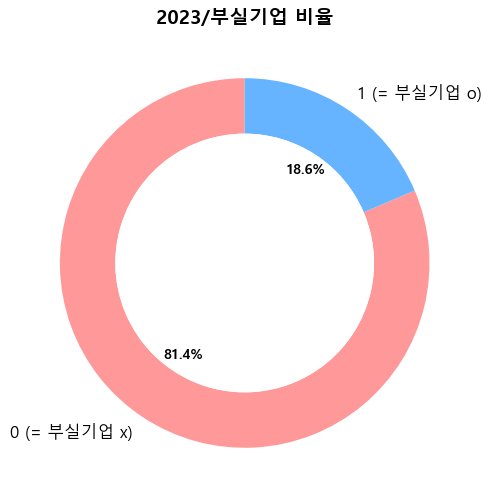

In [4]:
# '2023/부실기업' 비율 계산
value_counts = data_21to22['2023/부실기업'].value_counts()
labels = ['1 (= 부실기업 o)' if label == 1 else '0 (= 부실기업 x)' for label in value_counts.index]
sizes = value_counts.values

# 색상 설정
colors = ['#ff9999','#66b3ff']

# 도넛 차트 시각화
fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(aspect="equal"))

wedges, texts, autotexts = ax.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90, wedgeprops=dict(width=0.3))

# 도넛 차트의 가운데에 텍스트 추가
centre_circle = plt.Circle((0, 0), 0.70, fc='white')
fig.gca().add_artist(centre_circle)

# 텍스트 스타일 설정
plt.setp(autotexts, size=10, weight="bold", color="black")
plt.setp(texts, size=12)

# 차트 제목 추가
plt.title('2023/부실기업 비율', fontsize=14, weight='bold')

# 차트 표시
plt.show()

데이터 불균형 -> 평가지표로 accuracy(정확도)가 아닌 F1-score를 기준으로 한다.

In [5]:
data_21to22.head()

,업체코드,종목명,상장여부,2023/부실기업,2022/총자산증가율,2022/매출액증가율,2021/영업이익증가율,2021/순이익증가율,2021/총자본영업이익율,2022/총자본영업이익율,...,2022/인건비(종업원1인당),2021/노동장비율(종업원1인당),2021/자본집약도(종업원1인당),2021/법인세차감전순이익(구성비),2022/법인세차감전순이익(구성비),2021/인건비(구성비),2021/금융비용(구성비),2022/금융비용(구성비),2021/임차료(구성비),2022/임차료(구성비)
0,N350605,동화약품,1,0,3.27,16.06,-16.09,-48.20,4.56,6.28,...,60853590.0,1.583593e+08,5.627382e+08,17.87,15.335,57.855,3.18,4.5,1.28,1.32
1,N320498,KR모터스,1,1,-0.52,-15.04,16.26,24.22,-1.02,-4.95,...,60853590.0,1.295734e+09,1.767904e+09,17.87,15.335,57.855,3.18,4.5,1.28,1.32
2,N320684,경방,1,0,-6.09,-0.71,13.04,-10.40,2.36,3.13,...,60853590.0,1.824437e+08,6.096943e+09,17.87,15.335,57.855,3.18,4.5,1.28,1.32
3,N320730,삼양홀딩스,1,0,-0.76,-40.09,218.01,225.02,12.76,3.32,...,60853590.0,1.521873e+08,3.949607e+09,17.87,15.335,57.855,3.18,4.5,1.28,1.32
4,N310581,하이트진로,1,0,-9.43,12.40,-16.74,39.18,4.61,5.06,...,60853590.0,5.633133e+08,1.039853e+09,17.87,15.335,57.855,3.18,4.5,1.28,1.32


In [6]:
data_21to22.columns

Index(['업체코드', '종목명', '상장여부', '2023/부실기업', '2022/총자산증가율', '2022/매출액증가율',
       '2021/영업이익증가율', '2021/순이익증가율', '2021/총자본영업이익율', '2022/총자본영업이익율',
       '2022/총자본법인세비용차감전순이익율', '2022/총자본순이익율', '2021/기업법인세비용차감전순이익율',
       '2022/기업법인세비용차감전순이익율', '2021/기업순이익율', '2021/경영자본영업이익율',
       '2022/경영자본영업이익율', '2022/자기자본법인세비용차감전순이익율', '2021/자기자본순이익율',
       '2021/자본금법인세비용차감전순이익율', '2022/자본금법인세비용차감전순이익율', '2021/자본금순이익율',
       '2022/자본금순이익율', '2021/매출액법인세비용차감전순이익율', '2022/매출액법인세비용차감전순이익율',
       '2022/매출액총이익율', '2022/매출액영업이익율', '2022/감가상각비/총비용비율',
       '2021/조세/조세차감전순이익비율', '2022/조세/조세차감전순이익비율', '2022/금융비용/총부채',
       '2021/차입금평균이자율', '2022/차입금평균이자율', '2021/금융비용/총비용비율', '2022/금융비용/총비용비율',
       '2021/영업이익이자보상비율', '2022/영업이익이자보상비율', '2021/법인세차감전순이익이자보상비율',
       '2022/법인세차감전순이익이자보상비율', '2022/배당성향', '2021/상환계수(세전이익)', '2021/부채상환계수',
       '2021/대출효율성계수(법인세비용차감전순이익)', '2022/EBIT대매출액(세전이익)', '2022/EBITDA대매출액',
       '2021/EBITDA대금융비용', '2022/EBITDA대금융비용', '2021/자기자본비율', '2021/당좌비율',
      

In [7]:
# 2021년과 2022년 변수 목록 추출
ratios_2021 = data_21to22.filter(like='2021').columns
ratios_2022 = data_21to22.filter(like='2022').columns

# 공통 재무 비율 찾기
common_ratios = set(ratios_2021.str.replace('2021/', '')) & set(ratios_2022.str.replace('2022/', ''))

# 결과 출력
common_ratios_list = sorted(list(common_ratios))
common_ratios_list

['EBITDA대금융비용',
 '경영자본영업이익율',
 '금융비용(구성비)',
 '금융비용/총비용비율',
 '기업법인세비용차감전순이익율',
 '매출액법인세비용차감전순이익율',
 '법인세차감전순이익(구성비)',
 '법인세차감전순이익이자보상비율',
 '사내유보율',
 '순운전자본/총자본비율',
 '순이익(종업원1인당)',
 '영업이익이자보상비율',
 '유동부채비율',
 '유보액/총자산비율',
 '임차료(구성비)',
 '자본금법인세비용차감전순이익율',
 '자본금순이익율',
 '조세/조세차감전순이익비율',
 '차입금평균이자율',
 '총자본영업이익율',
 '현금비율']

---

### 2. 모델링

In [8]:
# 모델 학습 함수
def train_models(data):
    global models, final_model

    # 종속 변수 설정
    y = data['2023/부실기업']

    # 카테고리별 변수 목록
    # 카테고리별 변수 목록 및 설명
    categories = {
        '수익성 비율': [
            '총자본영업이익율',
            '기업법인세비용차감전순이익율',
            '경영자본영업이익율',
            '매출액법인세비용차감전순이익율',
            '자본금법인세비용차감전순이익율',
            '자본금순이익율',
            '순이익(종업원1인당)',
            '법인세차감전순이익이자보상비율',
            '영업이익이자보상비율'
        ],
        # 기업이 얼마나 효율적으로 수익을 창출하고 있는지를 평가
        
        '레버리지 비율': [
            '차입금평균이자율',
            '금융비용/총비용비율'
        ],
        # 기업이 부채를 통해 자금을 조달하는 정도와 관련된 비율

        '유동성 비율': [
            '유동부채비율',
            '순운전자본/총자본비율',
            '현금비율'
        ],
        # 기업의 단기적인 재무 건전성을 평가

        '자본 비율': [
            '사내유보율',
            '유보액/총자산비율',
            '임차료(구성비)'  # 임차료는 일반적으로 운영 비용으로 분류되지만, 자본 구조와 관련해 언급될 수 있음
        ],
        # 기업의 자본 구조와 자산 조달의 안정성을 평가

        '효율성 비율': [
            'EBITDA대금융비용',
            '법인세차감전순이익(구성비)',
            '조세/조세차감전순이익비율',
            '금융비용(구성비)'
        ]
        # 자산과 자본을 얼마나 효율적으로 사용하는지를 평가
    }

    models = {}

    # 각 카테고리별 모델 학습
    for category, vars_list in categories.items():
        # 해당 카테고리의 데이터 준비
        X_category = data[[f'2021/{var}' for var in vars_list] + [f'2022/{var}' for var in vars_list] + ['2023/부실기업']]
        y_category = X_category['2023/부실기업']
        X_category = X_category.drop(columns=['2023/부실기업'])  # 라벨 제외

        # 데이터 정규화
        scaler_cat = StandardScaler()
        X_category_scaled = scaler_cat.fit_transform(X_category)

        # LSTM 입력 형식으로 변환
        X_category_lstm = X_category_scaled.reshape((X_category_scaled.shape[0], 1, X_category_scaled.shape[1]))

        # 모델 구축
        model = Sequential()
        model.add(LSTM(64, activation='relu', return_sequences=True, input_shape=(X_category_lstm.shape[1], X_category_lstm.shape[2])))
        model.add(LSTM(64, activation='relu'))
        model.add(Dense(1, activation='sigmoid'))
        model.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])

        # 모델 학습
        model.fit(X_category_lstm, y_category, epochs=10, batch_size=32, verbose=0)

        # 모델 저장
        models[category] = {
            'model': model,
            'scaler': scaler_cat,
        }

    # 모든 카테고리의 변수로 최종 모델 학습
    all_vars = [var for vars_list in categories.values() for var in vars_list]
    X_all = data[[f'2021/{var}' for var in all_vars] + [f'2022/{var}' for var in all_vars]]

    # 최종 모델 학습을 위한 데이터 준비
    y_all = data['2023/부실기업'].values  # 실제 라벨
    X_all_scaled = StandardScaler().fit_transform(X_all)  # 새로운 스케일러로 스케일링

    # LSTM 입력 형식으로 변환
    X_all_lstm = X_all_scaled.reshape((X_all_scaled.shape[0], 1, X_all_scaled.shape[1]))

    # 최종 모델 구축
    final_model = Sequential()
    final_model.add(LSTM(64, activation='relu', return_sequences=True, input_shape=(X_all_lstm.shape[1], X_all_lstm.shape[2])))
    final_model.add(LSTM(64, activation='relu'))
    final_model.add(Dense(1, activation='sigmoid'))
    final_model.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])

    # 최종 모델 학습
    final_model.fit(X_all_lstm, y_all, epochs=10, batch_size=32, verbose=1)

# 예측 및 시각화 함수
def predict_and_visualize(new_data):
    global models, final_model

    # 업체 코드와 종목명 추출
    company_code = new_data['업체코드'].values[0]
    company_name = new_data['종목명'].values[0]

    # 카테고리별 변수 목록 및 설명
    categories = {
        '수익성 비율': [
            '총자본영업이익율','기업법인세비용차감전순이익율','경영자본영업이익율',
            '매출액법인세비용차감전순이익율','자본금법인세비용차감전순이익율','자본금순이익율',
            '순이익(종업원1인당)','법인세차감전순이익이자보상비율','영업이익이자보상비율'
        ],
        
        '레버리지 비율': [
            '차입금평균이자율','금융비용/총비용비율'
        ],

        '유동성 비율': [
            '유동부채비율','순운전자본/총자본비율','현금비율'
        ],

        '자본 비율': [
            '사내유보율','유보액/총자산비율','임차료(구성비)'  
        ],

        '효율성 비율': [
            'EBITDA대금융비용','법인세차감전순이익(구성비)',
            '조세/조세차감전순이익비율','금융비용(구성비)'
        ]
    }

    predicted_probabilities = []

    # 각 카테고리별 모델 예측
    for category, data in models.items():
        model = data['model']
        scaler = data['scaler']

        # 새로운 데이터에서 해당 카테고리의 변수만 선택 (2021년과 2022년 변수 모두 포함)
        new_data_filtered = new_data[[f'2021/{var}' for var in categories[category]] + [f'2022/{var}' for var in categories[category]]]

        # 새로운 데이터 정규화
        new_data_scaled = scaler.transform(new_data_filtered)

        # LSTM 입력 형식으로 변환
        new_data_lstm = new_data_scaled.reshape((new_data_scaled.shape[0], 1, new_data_scaled.shape[1]))

        # 예측 수행
        predictions_proba = model.predict(new_data_lstm)
        predicted_probability = np.mean(predictions_proba)  # 평균 확률을 사용
        predicted_probabilities.append(predicted_probability)

    # 방사형 차트 시각화
    def create_radar_chart(ax, data, categories, title):
        num_vars = len(categories)
        angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
        
        # 첫 번째 값을 끝에 추가하여 연결
        data = np.concatenate((data, [data[0]]))
        angles += angles[:1]

        ax.set_theta_offset(np.pi / 2)
        ax.set_theta_direction(-1)

        ax.set_rlabel_position(0)
        ax.set_ylim(0, 1)  # y축 범위를 0에서 1로 고정
        ax.plot(angles, data, color='blue', linewidth=2, linestyle='solid')
        ax.fill(angles, data, color='blue', alpha=0.25)

        ax.set_xticks(angles[:-1])
        ax.set_xticklabels(categories, fontsize=12)
        ax.set_title(title, size=15, y=1.1)

    # 서브플롯으로 방사형 차트와 막대 그래프 그리기
    fig, axs = plt.subplots(1, 2, figsize=(12, 6), gridspec_kw={'width_ratios': [2, 1]})

    # 방사형 차트 그리기
    ax_radar = plt.subplot(1, 2, 1, polar=True)
    create_radar_chart(ax_radar, predicted_probabilities, list(models.keys()), f'Impact of Financial Ratios on Bankruptcy Prediction\n\n({company_code}, {company_name})')

    # 막대 그래프 그리기
    ax_bar = plt.subplot(1, 2, 2)
    ax_bar.bar(['Final Bankruptcy Prediction Probability'], [np.mean(predicted_probabilities)], color='orange', width=0.3)
    ax_bar.axhline(y=0.5, color='red', linestyle='--', label='Threshold (0.5)')
    ax_bar.set_ylim(0, 1)
    ax_bar.set_ylabel('Probability')
    ax_bar.set_title('Final Bankruptcy Prediction Probability')
    ax_bar.legend()

    plt.tight_layout()
    plt.show()

# 데이터 로드 및 모델 학습
data_21to22 = pd.read_csv("../../project/data/data_21to22.csv", encoding='utf-8-sig', low_memory=False)
train_models(data_21to22)

Epoch 1/10
863/863 [==============================] - 4s 2ms/step - loss: 0.2587 - accuracy: 0.8899
Epoch 2/10
863/863 [==============================] - 1s 2ms/step - loss: 0.1796 - accuracy: 0.9205
Epoch 3/10
863/863 [==============================] - 2s 2ms/step - loss: 0.1601 - accuracy: 0.9295
Epoch 4/10
863/863 [==============================] - 2s 2ms/step - loss: 0.1510 - accuracy: 0.9336
Epoch 5/10
863/863 [==============================] - 2s 2ms/step - loss: 0.1446 - accuracy: 0.9360
Epoch 6/10
863/863 [==============================] - 1s 2ms/step - loss: 0.1398 - accuracy: 0.9382
Epoch 7/10
863/863 [==============================] - 1s 2ms/step - loss: 0.1360 - accuracy: 0.9399
Epoch 8/10
863/863 [==============================] - 2s 2ms/step - loss: 0.1328 - accuracy: 0.9401
Epoch 9/10
863/863 [==============================] - 1s 2ms/step - loss: 0.1305 - accuracy: 0.9427
Epoch 10/10
863/863 [==============================] - 2s 2ms/step - loss: 0.1275 - accuracy: 0.9430

In [9]:
import pandas as pd

# '2023/부실기업' 변수의 값이 1인 행 필터링
bankrupt_indices = data_21to22[data_21to22['2023/부실기업'] == 1].index

# 상위 30개 인덱스 출력
print(bankrupt_indices[:30])

Int64Index([  1,   8,  11,  17,  29,  31,  32,  38,  40,  47,  55,  56,  61,
             64,  68,  79,  81,  86,  89, 100, 106, 112, 116, 118, 123, 135,
            138, 145, 152, 169],
           dtype='int64')


#### [ 부실기업 x ]

1/1 [==============================] - 0s 189ms/step


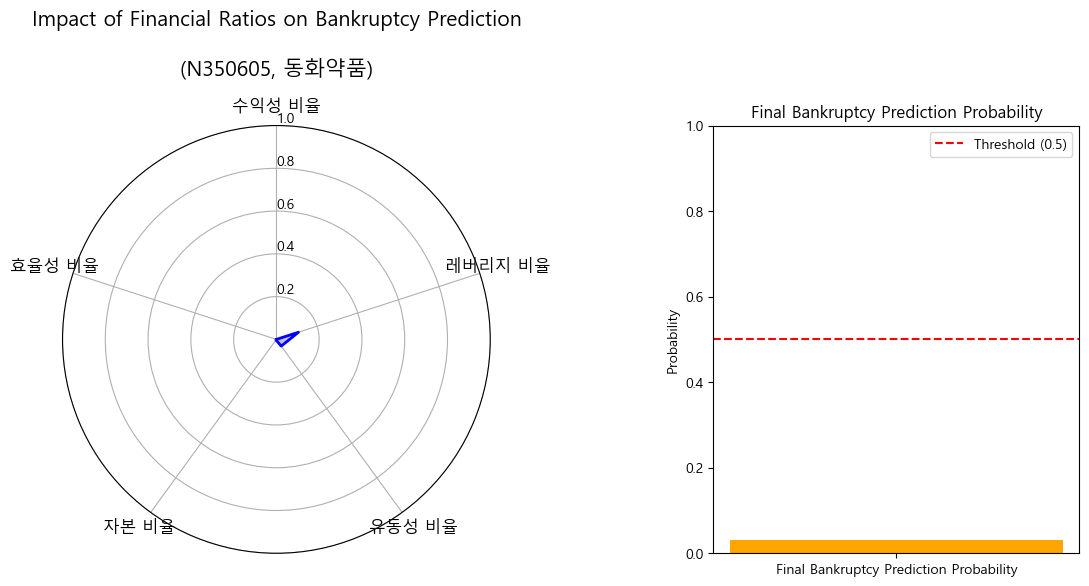

In [10]:
# 특정 인덱스의 데이터 선택
index = 0  # 원하는 인덱스
new_data = data_21to22.iloc[[index]]  # 인덱스에 해당하는 데이터 선택

# 예측 및 시각화 수행
predict_and_visualize(new_data)

1/1 [==============================] - 0s 13ms/step


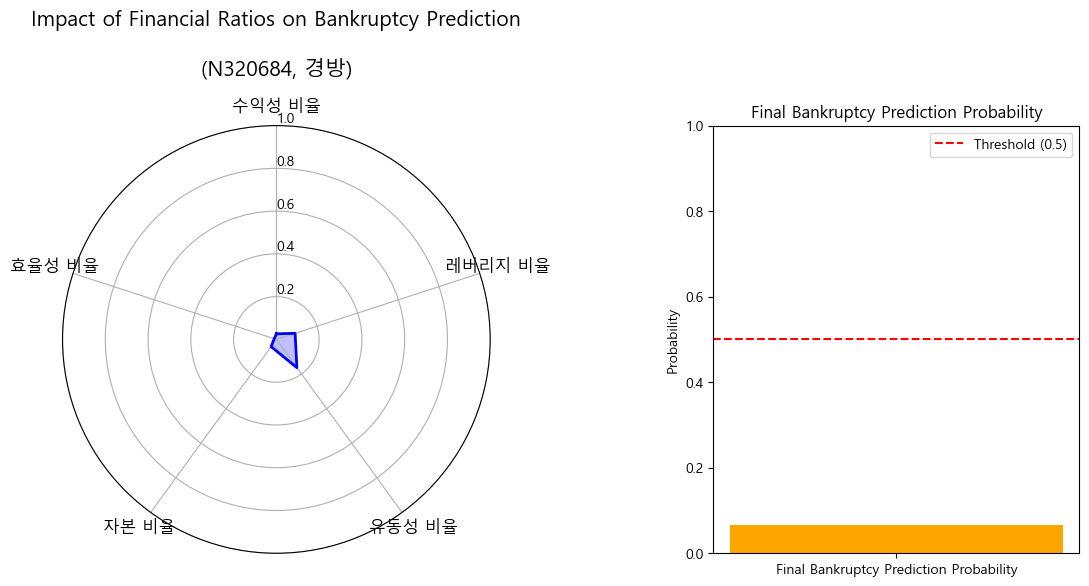

In [11]:
# 특정 인덱스의 데이터 선택
index = 2  # 원하는 인덱스
new_data = data_21to22.iloc[[index]]  # 인덱스에 해당하는 데이터 선택

# 예측 및 시각화 수행
predict_and_visualize(new_data)

#### [ 부실기업 o ]

1/1 [==============================] - 0s 14ms/step


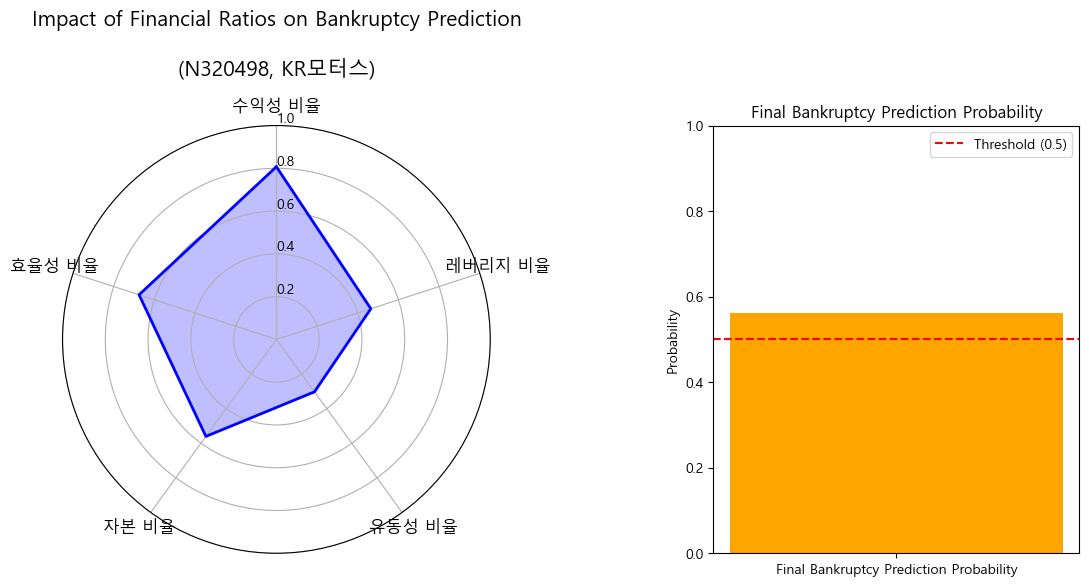

In [12]:
# 특정 인덱스의 데이터 선택
index = 1  # 원하는 인덱스
new_data = data_21to22.iloc[[index]]  # 인덱스에 해당하는 데이터 선택

# 예측 및 시각화 수행
predict_and_visualize(new_data)

1/1 [==============================] - 0s 15ms/step


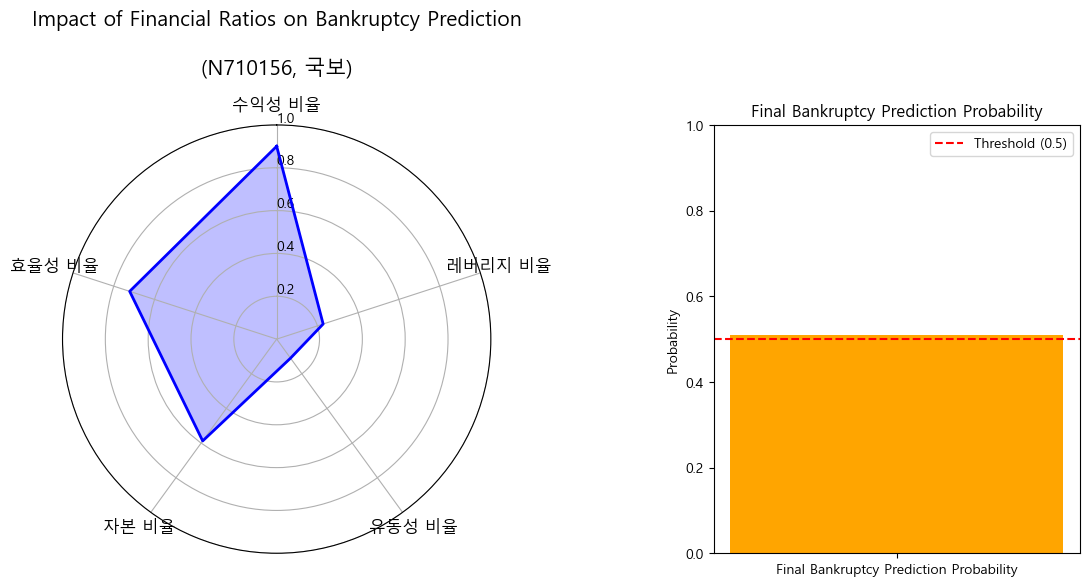

In [16]:
# 특정 인덱스의 데이터 선택
index = 55  # 원하는 인덱스
new_data = data_21to22.iloc[[index]]  # 인덱스에 해당하는 데이터 선택

# 예측 및 시각화 수행
predict_and_visualize(new_data)

1/1 [==============================] - 0s 15ms/step


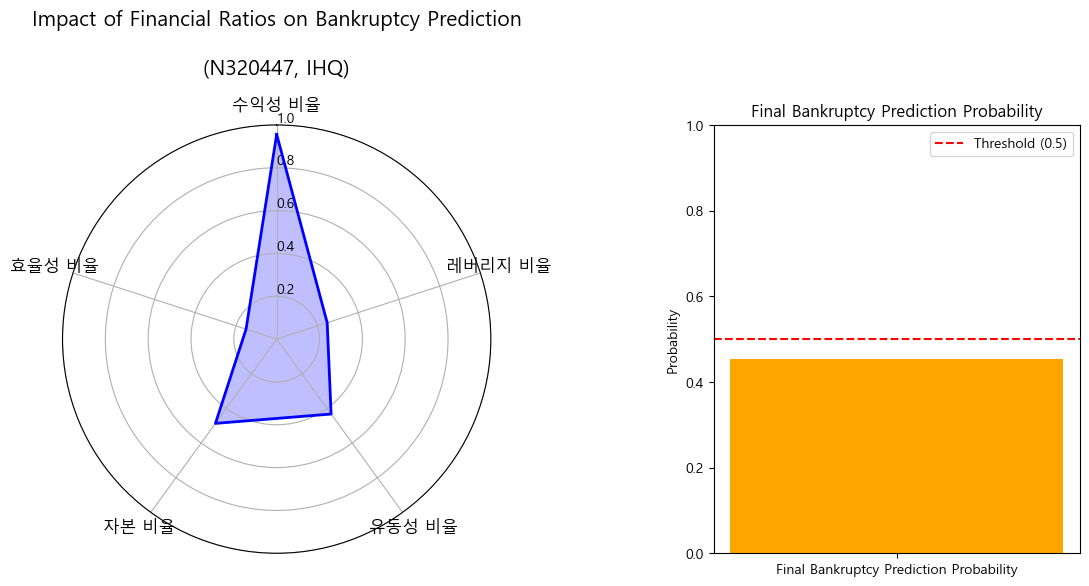

In [25]:
# 특정 인덱스의 데이터 선택
index = 169  # 원하는 인덱스
new_data = data_21to22.iloc[[index]]  # 인덱스에 해당하는 데이터 선택

# 예측 및 시각화 수행
predict_and_visualize(new_data)

.